In [1]:
import sys
import os
sys.path.append("../lib")
# np.set_printoptions(threshold=sys.maxsize)

import es1d

import numpy as np
import scipy.constants as cst
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from scipy.fft import fft, ifft, fftshift, fftfreq
from scipy.signal import spectrogram, csd, welch, coherence, savgol_filter
from scipy.optimize import curve_fit
import cmath

import matplotlib.animation as animation
from IPython import display

In [2]:
mpl.rcParams['xtick.labelsize'] = 13
mpl.rcParams['ytick.labelsize'] = 13
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['legend.fontsize'] = 16

# Simulation

In [1]:
alfas = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90]
path = '../../../../../mnt/c/Users/sebis/OneDrive - Università degli Studi di Milano-Bicocca/4anno/Fisica dei Plasmi I - Zerbi/Parte 1/3 PIC'
ppath = '/Dati/ES - Densità flusso variabile 7'

def simula(alfa):
    n_i = 1
    # alfa = 0.01
    n_p = (1. - alfa)*n_i
    n_b = alfa*n_i

    # ppc_p = int(50/n_p)
    # ppc_i = int(50/n_i)
    # ppc_b = int(50/n_b)
    ppc = 100
    ppc_p, ppc_i, ppc_b = ppc, ppc, ppc

    plasma = es1d.Species("Plasma", -1, ppc_p, vfl = 0., vth = 0.002, density = es1d.Density(type = 'uniform', n = n_p))
    ioni = es1d.Species("Ioni", 1836, ppc_i, vfl = 0., vth = 0.002, density = es1d.Density(type = 'uniform', n = n_i))
    beam = es1d.Species("Beam", -1, ppc_b, vfl = 0.02, vth = 0., density = es1d.Density(type = 'uniform', n = n_b))

    box = 400.
    nx = 1000
    dt = 0.4   # Courant's condition: dt <= dx, where dx = box/nx
    t_max = 8000
    n_iter = int(t_max/dt)

    Et = np.zeros((nx, n_iter))

    ## Run the simulation step by step
    sim = es1d.Simulation(nx, box, dt, species = [plasma, beam, ioni])

    print(f"ALFA = {alfa}")
    print("Running simulation up to t = {:g} ...".format(t_max))
    while sim.t < (t_max - dt):
        print('n = {:d}, t = {:g}'.format(sim.n, sim.t), end = '\r')
        Et[:,sim.n] = sim.field.E
        sim.iter()

    os.mkdir(path + ppath + '/a={:.2f}'.format(alfa))
    np.savetxt(path + ppath + '/a={:.2f}'.format(alfa) + '/Evoluzione campo elettrico.txt', Et)
    np.savetxt(path + ppath + '/a={:.2f}'.format(alfa) + '/Parametri simulativi.txt', [n_i, alfa, n_p, n_b, ppc])
    print('\nCampo e parametri salvati')
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    P = np.sum(Et**2, axis=0)
    Psg = savgol_filter(P, window_length = 30, polyorder = 3)
    ax.plot(np.linspace(0, 8000, 20000), Psg, label='Filtered', color='blue')
    ax.plot(np.linspace(0, 8000, 20000), P, alpha=0.3, label='Sampled')
    ax.set_title(rf"Evolution of Electric Field Energy   ---   $\alpha$ = {alfa}")
    ax.set_xlabel(r"$t$ [$\omega_n^{-1}$]")
    ax.set_ylabel(r"E energy [$m_e c^2$]")
    ax.set_yscale('log')
    ax.legend()
    ax.grid()
    fig.savefig(path + ppath + '/a={:.2f}'.format(alfa) + '/Energia.pdf')
    fig.savefig(path + ppath + '/a={:.2f}'.format(alfa) + '/Energia.png')
    plt.close()
    print('Energia salvata')

    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    Pxx, freqs, bins, im = ax.specgram(Et[100], Fs=(1/dt), interpolation='nearest')
    ax.set_title(r"Spectrogram at mid-grid ---  $f_{plasma} = 1/2\pi \simeq 0.16$")
    ax.set_ylabel(r"$f$ [$\omega_n$]")
    ax.set_xlabel(r"$t$ [$\omega_n^{-1}$]")
    ax.axhline(1/(2*cst.pi), 0, t_max, color='r', linestyle='--')
    fig.colorbar(im, ax=ax).set_label(r"$10 \cdot log_{10}\left(|FFT(E)^2|\right)$")
    fig.savefig(path + ppath + '/a={:.2f}'.format(alfa) + '/Spettrogramma.pdf')
    fig.savefig(path + ppath + '/a={:.2f}'.format(alfa) + '/Spettrogramma.png')
    plt.close()
    print('Spettrogramma salvato\n')

# Dispersion relation

In [19]:
alfas = ["0.01", "0.02", "0.03", "0.04", "0.05", "0.06", "0.07", "0.08", "0.09", "0.10", "0.20"]
m = 2

path = '../../../../../mnt/c/Users/sebis/OneDrive - Università degli Studi di Milano-Bicocca/4anno/Fisica dei Plasmi I - Zerbi/Parte 1/3 PIC'
ppath = '/Dati/ES - Densità flusso variabile 6'
# nr = alfas[m-1]
nr = "0.01"
filename = path + ppath + '/' + f'a={nr}' + '/Evoluzione campo elettrico.txt'
E = np.loadtxt(filename)
# plt.plot(np.linspace(0, 200, 200), E[:,1000])
print(filename)

../../../../../mnt/c/Users/sebis/OneDrive - Università degli Studi di Milano-Bicocca/4anno/Fisica dei Plasmi I - Zerbi/Parte 1/3 PIC/Dati/ES - Densità flusso variabile 6/a=0.01/Evoluzione campo elettrico.txt


In [4]:
def built_histo (histo, X, Y, dist, delta_f, delta_k):
    # 320 frequencies and 200 wavenumbers
    Yc = np.conjugate(Y)
    S_f = np.angle(Yc*X) / dist   # Arrays of length 320 made of k(f)
    Power = np.abs(Yc*X)
    
    indexes = np.zeros_like(S_f)   # Relate the wavenumber k(f) to indexes in 'hist'
    indexes = np.floor(S_f / delta_k)
    indexes = indexes.astype(int)   # Cast 'indexes' into an array of integers

    js = np.arange(320)   # Indexes of frequencies
    
    for index, j, p in zip(indexes, js, Power):
        histo[j, index] += p
        # print(p)
        # print(hist[j, index])

    return histo

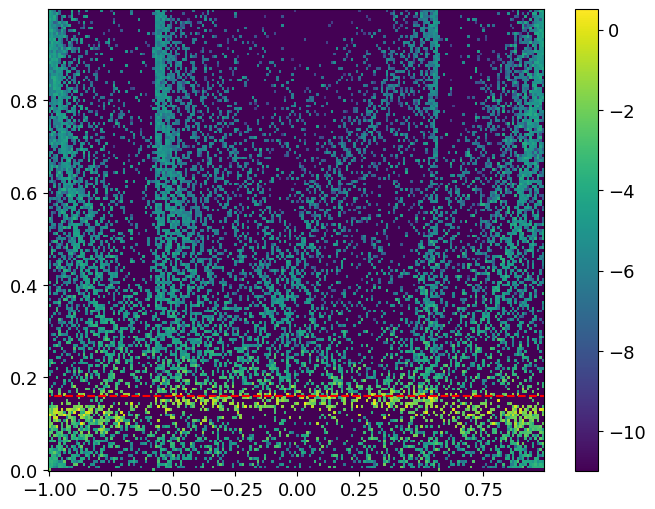

In [20]:
histo = np.zeros((320, 200))
dist = 2.

f = fftshift(fftfreq(320, 0.5))
k = fftshift(fftfreq(200, 0.5))
delta_f = f[1] - [0]
delta_k = k[1] - k[0]

t = np.linspace(0, 8000, 16000)
f = fftshift(fftfreq(320, t[1] - t[0]))

start_ind = 0
finish_ind = 320

while (finish_ind <= 15999):

    x = E[0, start_ind:finish_ind]
    y = E[4, start_ind:finish_ind]
    X = fftshift(fft(x))
    Y = fftshift(fft(y))

    histo = built_histo(histo, X, Y, dist, delta_f, delta_k)
    
    start_ind += 160
    finish_ind += 160
    # print(finish_ind)

# print(histo)

# fig, ax = plt.subplots(1, 1, figsize=(12,4))
plt.figure(figsize=(8, 6))
plt.pcolormesh(k, f[160:], np.log10(histo[160:] + 1e-11), shading='nearest')
plt.axhline(1/(2*cst.pi), -1, 1, color='r', linestyle='--')
plt.colorbar()
plt.show()

# # ax.plot(f, np.abs(F))
# ax.plot(f, np.angle(Y, deg=True), alpha=0.5)
# ax.plot(f, np.angle(Yc, deg=True), alpha=0.5)
# ax.grid()

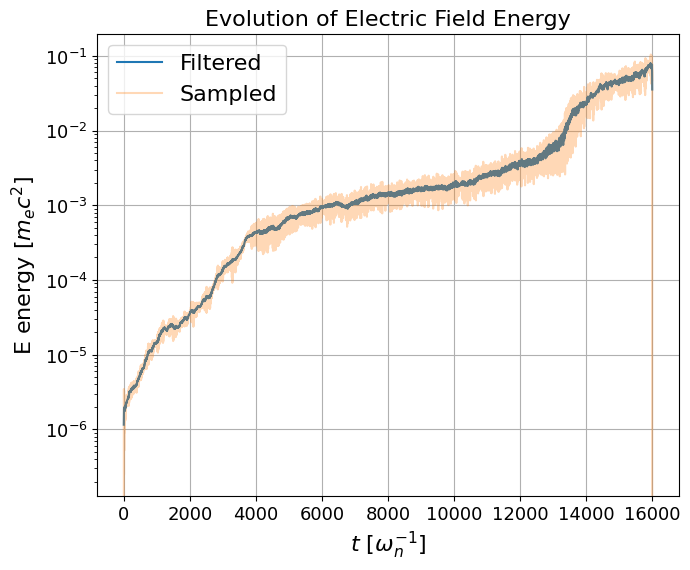

In [21]:
P = np.sum(E**2, axis=0)
Psg = savgol_filter(P, window_length = 30, polyorder = 3)
tempi = np.linspace(0, 16000, 16000)

# fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 11))
fig, ax1 = plt.subplots(1, 1, figsize=(7.5, 6))


ax1.plot(tempi, Psg, label='Filtered')
ax1.plot(tempi, P, alpha=0.3, label='Sampled')
ax1.set_title("Evolution of Electric Field Energy")
ax1.set_xlabel(r"$t$ [$\omega_n^{-1}$]")
ax1.set_ylabel(r"E energy [$m_e c^2$]")
ax1.legend()
# ax1.set_ylim(0, 0.0025)
ax1.set_yscale('log')
ax1.grid()
